In [3]:
import ushertools
import gzip

In [4]:
mat = ushertools.UsherMutationAnnotatedTree(gzip.open("/mnt/d/public-latest.all.masked.pb.gz"))

Reading condensed nodes dict |████████████████████████████████████████| 747877/747877 [100%] in 1.5s (483101.96/s) 
Loading tree, this may take a while...
Annotating nuc muts |████████████████████████████████████████| 4195849/4195849 [100%] in 27.9s (150512.67/s) 
Expanding condensed nodes |████████████████████████████████████████| 2934545/2934545 [100%] in 18.2s (161409.08/s) 
Loaded initial tree with 6301887 tips
Tree to use now has 6301887 tips
Setting branch length |████████████████████████████████████████| 7563191/7563191 [100%] in 5.6s (1341366.70/s) 


In [5]:
import tqdm, datetime
def assign_final_genotypes(tree):
    for node in tqdm.tqdm(tree.traverse_preorder()):
        if node.parent:
            positions = {x.one_indexed_position for x in node.nuc_mutations}
            filtered_muts = [x for x in node.parent.nuc_mutations if x.one_indexed_position not in positions]
            node.nuc_mutations = filtered_muts + node.nuc_mutations
assign_final_genotypes(mat.tree)

7563191it [00:51, 147537.78it/s]


In [6]:

from collections import defaultdict
by_week = defaultdict(list)
for node in tqdm.tqdm(mat.tree.traverse_leaves()):
    components = node.label.split("|")
    if len(components) ==2:
        name, date = components
    elif len(components) == 3:
        name, genbank, date = components
    else:
        raise ValueError("Unexpected label format: %s" % node.label)
    
    # if date is not like yyyy-mm-dd, then skip
    if len(date) != 10:
        continue
    
    # check name starts with Eng, Wal, Scot
    if not name.startswith("Eng") and not name.startswith("Wal") and not name.startswith("Scot"):
        continue

    parsed_date = datetime.datetime.strptime(date, "%Y-%m-%d")
    rounded_to_week = parsed_date - datetime.timedelta(days=parsed_date.weekday())
    rounded_string = rounded_to_week.strftime("%Y-%m-%d")
    by_week[rounded_string].append(node)


6301887it [00:32, 195750.12it/s]


In [7]:
single_week = by_week["2022-06-27"]

In [8]:
single_week[0].nuc_mutations

[NucMutation(one_indexed_position=14408, par_nuc='C', mut_nuc='T', ref_nuc='C', chromosome='chrom', type='nt'),
 NucMutation(one_indexed_position=241, par_nuc='C', mut_nuc='T', ref_nuc='C', chromosome='chrom', type='nt'),
 NucMutation(one_indexed_position=3037, par_nuc='C', mut_nuc='T', ref_nuc='C', chromosome='chrom', type='nt'),
 NucMutation(one_indexed_position=23403, par_nuc='A', mut_nuc='G', ref_nuc='A', chromosome='chrom', type='nt'),
 NucMutation(one_indexed_position=28881, par_nuc='G', mut_nuc='A', ref_nuc='G', chromosome='chrom', type='nt'),
 NucMutation(one_indexed_position=28882, par_nuc='G', mut_nuc='A', ref_nuc='G', chromosome='chrom', type='nt'),
 NucMutation(one_indexed_position=28883, par_nuc='G', mut_nuc='C', ref_nuc='G', chromosome='chrom', type='nt'),
 NucMutation(one_indexed_position=10029, par_nuc='C', mut_nuc='T', ref_nuc='C', chromosome='chrom', type='nt'),
 NucMutation(one_indexed_position=10449, par_nuc='C', mut_nuc='A', ref_nuc='C', chromosome='chrom', type='n

In [13]:
from collections import Counter
import math
def calc_entropy(single_position, total):

    ref = single_position[0].ref_nuc
    filtered = [x for x in single_position if x.mut_nuc != ref]
    counter = Counter([x.mut_nuc for x in filtered])
    # add in the reference, which has value total - sum(counter.values())
    ref_number= total - sum(counter.values())
    if ref_number > 0:
        counter[ref] = ref_number
    # calculate entropy
    entropy = 0
    for nuc, count in counter.items():
        p = count / total
        entropy -= p * math.log(p)
    return entropy


def mean_entropy_for_week(single_week):
    by_position = defaultdict(list)
    total = len(single_week)
    for node in single_week:
        for mut in node.nuc_mutations:
            by_position[mut.one_indexed_position].append(mut)
    entropy_by_position = {p: calc_entropy(by_position[p], total= total) for p in by_position}
    current_mean = sum(entropy_by_position.values()) / len(entropy_by_position)
    number_of_constant_sites  = 30e3 - len(entropy_by_position)
    entropy_for_constant_sites = 0
    weighted_average = (current_mean * len(entropy_by_position) + entropy_for_constant_sites * number_of_constant_sites) / (len(entropy_by_position) + number_of_constant_sites)
    return weighted_average

week_to_entropy = {w: mean_entropy_for_week(single_week) for w, single_week in tqdm.tqdm(by_week.items())}


100%|██████████| 140/140 [00:26<00:00,  5.36it/s]


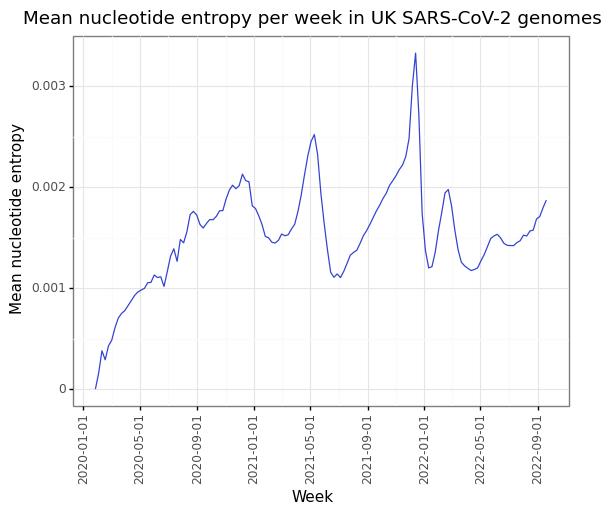

<ggplot: (8789178361423)>

In [31]:

sorted_weeks = sorted(week_to_entropy.keys())
sorted_entropies = [week_to_entropy[w] for w in sorted_weeks]
from plotnine import *
import pandas as pd
df = pd.DataFrame({"week": sorted_weeks, "entropy": sorted_entropies})
# remove final week
df = df[df.week != df.week.max()]
# convert week to datetime
df["week"] = pd.to_datetime(df["week"])

(ggplot(df, aes(x="week", y="entropy")) + geom_line(color="#3242d1") + theme_bw() + theme(axis_text_x=element_text(angle=90, hjust=0.5)) + labs(x="Week", y="Mean nucleotide entropy",title="Mean nucleotide entropy per week in UK SARS-CoV-2 genomes"))


In [ ]:
# calculate the entropy of a fair coin  

In [32]:
# calculate the entropy of a fair 6-sided die
import math
def calc_entropy_die():
    total = 6
    counter = Counter([1,2,3,4,5,6])
    # calculate entropy
    entropy = 0
    for nuc, count in counter.items():
        p = count / total
        entropy -= p * math.log(p)
    return entropy
calc_entropy_die()

1.7917594692280547